In [ ]:
import sys
import os

os.chdir("../")

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import PercentFormatter

# Is a user that once selects the $n^{th}$ accomodation in price likely to select again the $n^{th}$ in the future?

In [2]:
df = pd.read_csv('dataset/original/train.csv')
df = df[df['action_type'] == 'clickout item']
df = df[~df['reference'].isnull()]

df_test = pd.read_csv('dataset/original/test.csv')
df_test = df_test[df_test['action_type'] == 'clickout item']
df_test = df_test[~df_test['reference'].isnull()]

df = pd.concat([df, df_test], ignore_index=True)

In [6]:
def func(x):
    m = -1
    mr = 0
    var = 0
    iters = 1
    if len(x) > 1:
        for idx, row in x.iterrows():
            impression = list(map(int, row['impressions'].split('|')))
            prices = list(map(int, row['prices'].split('|')))
            clickout_item = int(row['reference'])
            impression_prices = [[impression[i], prices[i]] for i in range(len(impression))]
            impression_prices.sort(key=lambda e: int(e[1]))
            impression = [e[0] for e in impression_prices]
            if clickout_item in impression:
                i = impression.index(clickout_item)
                if m == -1:
                    m = i
                else:
                    m += i
                    mr = m/iters
                    var += abs(mr - i)
            iters += 1
        var = var/len(x)
        m = m/len(x)
        d = {'mean cheap': [m], 'std cheap': [var], 'num of clickouts': [len(x)]}
        return pd.DataFrame(data=d)

In [7]:
grouped = df.groupby(['user_id']).apply(func)
grouped_more_clickouts = grouped[grouped['num of clickouts'] > 1]

### A user that picks on a previous clickout the $n^{th}$ cheapest accomodation is really likely to stick with it

In [8]:
sum(grouped_more_clickouts['std cheap'].values)/len(grouped_more_clickouts)

1.8020275172577096

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2169e17748>]],
      dtype=object)

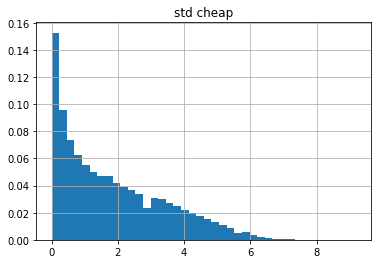

In [9]:
grouped_more_clickouts.hist(column = 'std cheap', bins = 40, weights = np.ones(len(grouped_more_clickouts))/len(grouped_more_clickouts))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f215eae3d68>]],
      dtype=object)

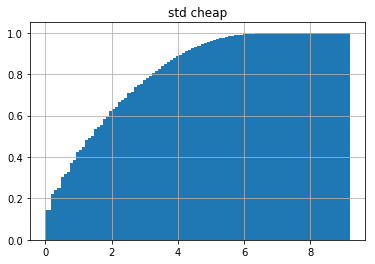

In [10]:
grouped_more_clickouts.hist(cumulative = True, column = 'std cheap', bins = 100, weights = np.ones(len(grouped_more_clickouts))/len(grouped_more_clickouts))

# Does it make more sense to look to the std deviation of the real prices instead of looking to the std deviation of the price-wise position?

In [11]:
def func1(x):
    m = -1
    mr = 0
    var = 0
    iters = 1
    if len(x) > 1:
        for idx, row in x.iterrows():
            impression = list(map(int, row['impressions'].split('|')))
            prices = list(map(int, row['prices'].split('|')))
            clickout_item = int(row['reference'])
            if clickout_item in impression:
                i = prices[impression.index(clickout_item)]
                if m == -1:
                    m = i
                else:
                    m += i
                    mr = m/iters
                    var += abs(mr - i)
            iters += 1
        var = var/len(x)
        m = m/len(x)
        d = {'mean price': [m], 'std price': [var], 'num of clickouts': [len(x)]}
        return pd.DataFrame(data=d)

In [12]:
grouped_price_more_clickouts = df.groupby(['user_id']).apply(func1)

In [13]:
sum(grouped_price_more_clickouts['std price'].values)/len(grouped_price_more_clickouts)

14.505426219015927

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2166687f28>]],
      dtype=object)

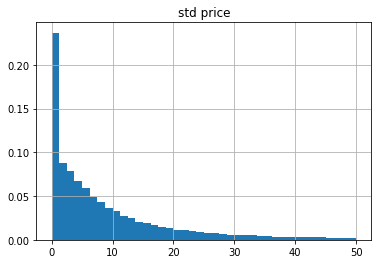

In [14]:
grouped_price_more_clickouts.hist(column = 'std price', bins = 40, range=[0, 50], weights = np.ones(len(grouped_price_more_clickouts))/len(grouped_price_more_clickouts))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f216d725a90>]],
      dtype=object)

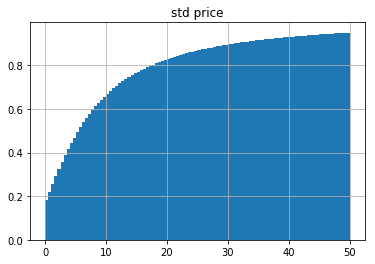

In [15]:
grouped_price_more_clickouts.hist(cumulative = True, column = 'std price', bins = 100, range=[0, 50], weights = np.ones(len(grouped_price_more_clickouts))/len(grouped_price_more_clickouts))

# Do we have less variance considering only the last clickout of a user instead of the mean of all the previous clickouts?

In [16]:
def func2(x):
    if len(x) > 1:
        iters = 1
        last_row = None
        var = []
        for idx, row in x.iterrows():
            if iters == 1:
                last_row = row
            else:
                impression = list(map(int, row['impressions'].split('|')))
                prices = list(map(int, row['prices'].split('|')))
                clickout_item = int(row['reference'])
                last_impression = list(map(int, last_row['impressions'].split('|')))
                last_prices = list(map(int, last_row['prices'].split('|')))
                last_clickout_item = int(last_row['reference'])
                if clickout_item in impression and last_clickout_item in last_impression:
                    price = prices[impression.index(clickout_item)]
                    last_price = last_prices[last_impression.index(last_clickout_item)]
                    var.append(abs(price - last_price))
                last_row = row
            iters += 1
        d = {'diff wrt preceding clickout price': var}
        return pd.DataFrame(data=d)

In [17]:
grouped_std_price_preceding_clickouts = df.groupby(['user_id']).apply(func2)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f216d408898>]],
      dtype=object)

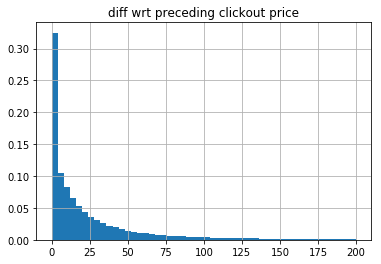

In [18]:
grouped_std_price_preceding_clickouts.hist(column = 'diff wrt preceding clickout price', bins = 50, range=[0, 200], weights = np.ones(len(grouped_std_price_preceding_clickouts))/len(grouped_std_price_preceding_clickouts))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f216cfb09b0>]],
      dtype=object)

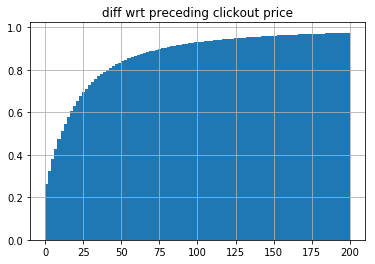

In [19]:
grouped_std_price_preceding_clickouts.hist(cumulative = True, column = 'diff wrt preceding clickout price', bins = 100, range=[0, 200], weights = np.ones(len(grouped_std_price_preceding_clickouts))/len(grouped_std_price_preceding_clickouts))